# Классификация токсичных комментариев (BERT)




Этот ноутбук — **дополнение** к основному решению (TF-IDF + классические модели).  
Здесь показывается обучение трансформера (BERT/DistilBERT) для распознования токсичных комментариев.

**Важно:** для трансформеров предобработка (лемматизация и т.п.) обычно не нужна — используем сырой текст из колонки `text`.

Импортируем необходимые библиотеки, зададим seed, проверим использование cuda.

## Импорты и загрузка данных

In [4]:
import os
import random
import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset as TorchDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed
)

SEED = 42
set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

Загрузим датасет.

In [5]:
data = pd.read_csv("datasets/toxic_comments.csv", index_col=0)

# Минимальная чистка
data["text"] = data["text"].fillna("").astype(str)
data["toxic"] = data["toxic"].astype(int)

data.head()


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Подготовка к обучению

Произведем сплиты, проверим долю таргета.

In [6]:
X = data[["text"]]
y = data["toxic"]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=SEED, stratify=y_train_full
)

print("train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)
print("train toxic share:", y_train.mean().round(4))
print("val   toxic share:", y_val.mean().round(4))
print("test  toxic share:", y_test.mean().round(4))


train: (101548, 1) val: (17921, 1) test: (39823, 1)
train toxic share: 0.1016
val   toxic share: 0.1016
test  toxic share: 0.1016


Можем видеть, что доля таргета везде одинакова за счет `stratify=y_train_full`.

Загружаем BERT и соответствующий токенайзер, а также задаём максимальную длину текста.

In [22]:
MODEL_NAME = "distilbert-base-uncased"
# MODEL_NAME = "bert-base-uncased"

MAX_LEN = 256  

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.model_max_length


512

Создадим кастомный класс в стиле PyTorch, который токенизирует текст и возвращает `input_ids` (ID токенов — числовое представление текста), `attention_mask` (маска, отделяющая токены от паддинга) и `labels` (значение таргета).

In [8]:
class ToxicCommentsDataset(TorchDataset):
    """Dataset для Trainer: токенизация делается один раз в __init__."""
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.encodings = self.tokenizer(
            self.texts,
            truncation=True,
            max_length=self.max_len,
            padding=False
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


Формируем объекты класса по выборкам, оформляем объект, который добавит паддинг (DataCollatorWithPadding), а также проверим соотношение выборок.

In [9]:
train_dataset = ToxicCommentsDataset(X_train["text"], y_train, tokenizer, max_len=MAX_LEN)
val_dataset   = ToxicCommentsDataset(X_val["text"],   y_val,   tokenizer, max_len=MAX_LEN)
test_dataset  = ToxicCommentsDataset(X_test["text"],  y_test,  tokenizer, max_len=MAX_LEN)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

len(train_dataset), len(val_dataset), len(test_dataset)


(101548, 17921, 39823)

Оформляем объект AutoModelForSequenceClassification, который добавляет "классификационную голову" к предобученному трансформеру (BERT), чтобы выдавать предсказание класса 0/1.

Также создаём функцию compute_metrics для расчёта метрик на валидации.

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "balanced_accuracy": balanced_accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
    }


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Можно переходить к обучению.

## Обучение

Далее задаем параметры обучения (размер батча, learning_rate, число эпох, регуляризацию - L2) и создаём Trainer — готовую обёртку тренировочного цикла из Hugging Face для обучения и валидации модели.

In [13]:
BATCH_SIZE = 16 if torch.cuda.is_available() else 8

training_args = TrainingArguments(
    output_dir="bert_toxic_output",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=2,
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    logging_steps=50,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    #tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer


C:\Users\Вадим\AppData\Local\Temp\ipykernel_24968\183655824.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Запускаем обучение.

In [14]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.110800,0.109993,0.962781,0.915971,0.793191,0.857221,0.823964
2,0.046600,0.117046,0.967692,0.903606,0.853645,0.823174,0.838133


TrainOutput(global_step=12694, training_loss=0.08355303324919827, metrics={'train_runtime': 1704.2764, 'train_samples_per_second': 119.168, 'train_steps_per_second': 7.448, 'total_flos': 1.2395932811079072e+16, 'train_loss': 0.08355303324919827, 'epoch': 2.0})

Можно видеть, что метрики на валидации лучше, чем при стандартом NLP подходе в рамках основного ноутбука.

Далее определяем функции для расчёта вероятностей, подбора лучшего порога по F1 на val и вывода итоговых метрик при этом пороге (precision/recall/ROC-AUC и матрица ошибок).

In [26]:
def proba_from_logits(logits):
    """Берём вероятность класса 1 (toxic)."""
    return torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]

def find_best_threshold(y_true, proba, n_steps=101):
    thresholds = np.linspace(0, 1, n_steps)
    f1s = [f1_score(y_true, (proba >= t).astype(int), zero_division=0) for t in thresholds]
    best_idx = int(np.argmax(f1s))
    return float(thresholds[best_idx]), float(f1s[best_idx])

def report_metrics(y_true, proba, threshold):
    pred = (proba >= threshold).astype(int)

    print("threshold:", round(threshold, 4))
    print("F1:", round(f1_score(y_true, pred, zero_division=0), 4))
    print("Precision:", round(precision_score(y_true, pred, zero_division=0), 4))
    print("Recall:", round(recall_score(y_true, pred, zero_division=0), 4))
    print("Accuracy:", round(accuracy_score(y_true, pred), 4))
    print("Balanced accuracy:", round(balanced_accuracy_score(y_true, pred), 4))

    print("\n=== Ranking metrics (без threshold) ===")
    print("ROC-AUC:", round(roc_auc_score(y_true, proba), 4))
    print("PR-AUC (AP):", round(average_precision_score(y_true, proba), 4))

    print("\n=== Classification report ===")
    print(classification_report(y_true, pred, digits=4))

    cm = confusion_matrix(y_true, pred)
    ConfusionMatrixDisplay(cm).plot(values_format="d")
    plt.title("Confusion matrix")
    plt.show()


Делаем предсказания лучшей моделью на валидации, подбираем оптимальный порог и выводим метрики

Best threshold on VAL: 0.8250000000000001 Best F1: 0.843103448275862
threshold: 0.825
F1: 0.8431
Precision: 0.8843
Recall: 0.8056
Accuracy: 0.9695
Balanced accuracy: 0.8968

=== Ranking metrics (без threshold) ===
ROC-AUC: 0.9853
PR-AUC (AP): 0.9239

=== Classification report ===
              precision    recall  f1-score   support

           0     0.9782    0.9881    0.9831     16100
           1     0.8843    0.8056    0.8431      1821

    accuracy                         0.9695     17921
   macro avg     0.9312    0.8968    0.9131     17921
weighted avg     0.9687    0.9695    0.9689     17921



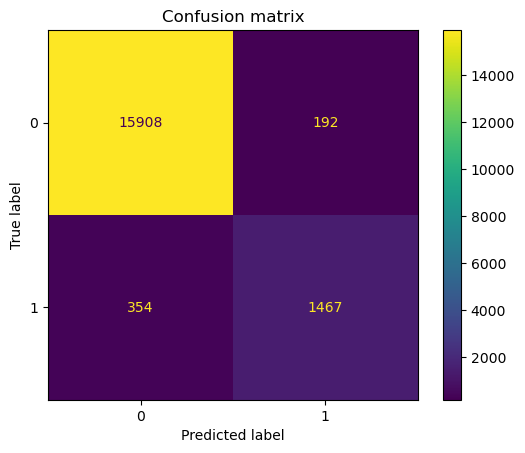

In [16]:
val_out = trainer.predict(val_dataset)
val_logits = val_out.predictions
val_labels = val_out.label_ids

val_proba = proba_from_logits(val_logits)

best_th, best_f1 = find_best_threshold(val_labels, val_proba, n_steps=201)
print("Best threshold on VAL:", best_th, "Best F1:", best_f1)

report_metrics(val_labels, val_proba, best_th)


Таким образом, BERT выдает на валидации показатели лучше, чем лучшая модель в классическом NLP подходе (LogReg TF-IDF). 

Разница (BERT − LogReg) на VAL:

F1: 0.8151 → 0.8431 (**+0.0280**)

precision: 0.8348 → 0.8843 (**+0.0495**)

recall: 0.7963 → 0.8056 (**+0.0093**)

ROC-AUC: 0.9780 → 0.9853 (**+0.0073**)

PR-AUC: 0.8972 → 0.9239 (**+0.0267**)

Accuracy: 0.9633 → 0.9695 (**+0.0062**)

Balanced accuracy: 0.8892 → 0.8968 (**+0.0076**)

Главное улучшение — F1 вырос за счет повышения и `precision`, и `recall`. В целом, все метрики заметно улучшились.

Порог получился высокий - 0.825, потому что модель “строже” ставит класс 1: токсичность предсказывается только при высокой уверенности — отсюда высокий `precision` при нормальном `recall`.

По матрице ошибок видно, что ложных срабатываний мало (FP=192), при этом часть токсичных комментариев всё ещё пропускается (FN=354).

Обучение, при этом, заняло сравнительно подольше, 1704 сек., в то время как LogReg обучился за 122 сек.

Далее перейдем к этапу тестирования.

## Тест

Теперь оценим модель на тесте на уже подобранном пороге (0.825).

threshold: 0.825
F1: 0.8423
Precision: 0.8791
Recall: 0.8085
Accuracy: 0.9692
Balanced accuracy: 0.8979

=== Ranking metrics (без threshold) ===
ROC-AUC: 0.9872
PR-AUC (AP): 0.9269

=== Classification report ===
              precision    recall  f1-score   support

           0     0.9785    0.9874    0.9830     35777
           1     0.8791    0.8085    0.8423      4046

    accuracy                         0.9692     39823
   macro avg     0.9288    0.8979    0.9126     39823
weighted avg     0.9684    0.9692    0.9687     39823



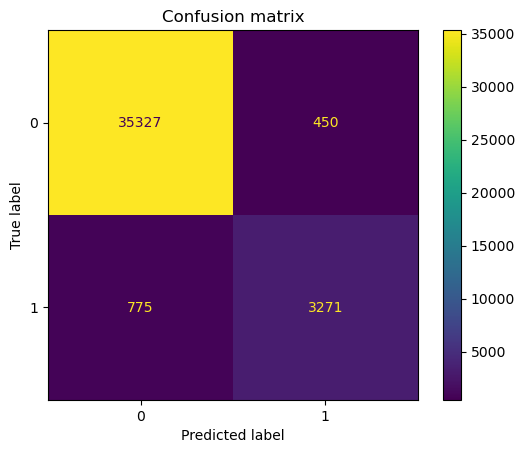

In [19]:
test_out = trainer.predict(test_dataset)
test_logits = test_out.predictions
test_labels = test_out.label_ids

test_proba = proba_from_logits(test_logits)

report_metrics(test_labels, test_proba, best_th)


На тесте BERT также обходит лучший классический baseline (LogReg TF-IDF) из основного ноутбука.

Разница (BERT − LogReg) на TEST:

F1: 0.8139 → 0.8423 (**+0.0284**)

precision: 0.8268 → 0.8791 (**+0.0523**)

recall: 0.8013 → 0.8085 (**+0.0072**)

ROC-AUC: 0.9791 → 0.9872 (**+0.0081**)

PR-AUC: 0.8970 → 0.9269 (**+0.0299**)

Accuracy: 0.9628 → 0.9692 (**+0.0064**)

Balanced accuracy: 0.8912 → 0.8979 (**+0.0067**)

Рост F1 снова обеспечивается в первую очередь заметным увеличением `precision` при небольшом росте `recall`: модель реже ошибочно помечает нетоксичные комментарии как токсичные и при этом не “просаживает” полноту.

Та же тенденция в матрице ошибок: FP=450, FN=775 — при выбранном пороге модель остаётся достаточно “консервативной”, снижая ложные срабатывания, но часть токсичных комментариев всё ещё пропускает.

## Сохранение модели

In [20]:
SAVE_DIR = "bert_toxic_model"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Saved to:", SAVE_DIR)


Saved to: bert_toxic_model


## Инференс

Также проведем небольшой показательный инференс модели, посмотрим с какой вероятностью она предсказывает показательные примеры текстов.

In [21]:
def predict_toxic(texts, threshold=best_th):
    """Возвращает вероятность токсичности и предсказанный класс по threshold."""
    if isinstance(texts, str):
        texts = [texts]

    enc = tokenizer(
        texts,
        truncation=True,
        max_length=MAX_LEN,
        padding=True,
        return_tensors="pt"
    ).to(device)

    trainer.model.eval()
    with torch.no_grad():
        logits = trainer.model(**enc).logits
        proba = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

    pred = (proba >= threshold).astype(int)
    return pd.DataFrame({"text": texts, "proba_toxic": proba, "pred_toxic": pred})

predict_toxic([
    "You are awesome, thank you!",
    "Shut up, you idiot!"
])


,text,proba_toxic,pred_toxic
0,"You are awesome, thank you!",0.000141,0
1,"Shut up, you idiot!",0.999620,1
